# **Baseline Model**

In [92]:
import pandas as pd
import numpy as np

# Load the data

df = pd.read_csv('rossmann_features.CSV', parse_dates=['week_start'])

# Naive Forecast

In [93]:
df['naive_pred'] = df['lag_1']

def smape(y_true,y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true)/(np.abs(y_true)+np.abs(y_pred)+1e-8))
smape_naive = smape(df['weekly_sales'], df['naive_pred'])
print(f'sMAPE (Naive): {smape_naive:.2f}%')


sMAPE (Naive): 28.91%


In [94]:
# Seasonal Naive

df = df.sort_values(['store','week_start'])

df['lag_52'] = df.groupby('store')['weekly_sales'].shift(52)

df['seasonal_naive_prediction'] = df['lag_52']

smape_seasonal = smape(df['weekly_sales'] , df['lag_52'])

print(f'sMAPE (Seasonsl Naive): {smape_seasonal:.2f}%')


sMAPE (Seasonsl Naive): 17.09%


In [95]:
# Moving Avg (4 Weeks)

df['moving_avg_pred'] = df['rolling_mean_4']

smape_ma = smape(df['weekly_sales'], df['moving_avg_pred'])
print(f"sMAPE (Moving Average): {smape_ma:.2f}%")


sMAPE (Moving Average): 34.93%


In [96]:
results = pd.DataFrame({
    "Model": ["Naive", "Seasonal Naive", "Moving Average"],
    "sMAPE": [smape_naive, smape_seasonal, smape_ma]
})
print(results)


            Model      sMAPE
0           Naive  28.910777
1  Seasonal Naive  17.086403
2  Moving Average  34.927714


# **Statistical  Model**

In [97]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

df = pd.read_csv('rossmann_features.CSV', parse_dates=['week_start'])
df = df.sort_values(['store','week_start'])





In [98]:


X = df.drop('weekly_sales', axis=1)
X = X.drop(['week_start','storetype','assortment'], axis=1)
y = df['weekly_sales']
X.head()

X_train,X_test,y_train,y_test=train_test_split(X , y , test_size=0.3, random_state= 0)


In [99]:
# Date boundary

cutoff_date = df['week_start'].max() - pd.Timedelta(weeks=8)


# Split the data 
X_train = X['week_start'] < cutoff_date
X_test = X['week_start'] >= cutoff_date

y_train = y[df['week_start'] < cutoff_date]
y_test  = y[df['week_start'] >= cutoff_date]

KeyError: 'week_start'

In [100]:
# Drop non numeric data

X_train.dtypes

store                          int64
weekly_customers               int64
promo_rate                   float64
month                          int64
year                           int64
week_of_year                   int64
quarter                        int64
is_month_start                 int64
is_month_end                   int64
lag_1                        float64
lag_2                        float64
lag_4                        float64
lag_12                       float64
rolling_mean_4               float64
rolling_std_4                float64
rolling_mean_12              float64
rolling_std_12               float64
promo_flag                     int64
promo_lag_1                  float64
competitiondistance          float64
competitionopensincemonth    float64
competitionopensinceyear     float64
promo2                         int64
dtype: object

# Random Forest and Linear Regression

In [111]:
random_forest = RandomForestRegressor(n_estimators=100,max_depth=3,random_state=0)
random_forest.fit(X_train,y_train)



RandomForestRegressor(max_depth=3, random_state=0)

In [112]:
y_pred = random_forest.predict(X_test)

def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

print("sMAPE:", smape(y_test, y_pred))


sMAPE: 14.64474467641236


In [107]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}


In [108]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all cores
    scoring='neg_mean_squared_error',  # Optimising for MSE
    verbose=2
)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_es

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  19.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   8.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  15.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  36.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  36.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  16.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  16.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  36.2s
[CV] END max_depth=None, 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
108 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
98 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-pa

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [109]:
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [110]:
y_pred_best = best_model.predict(X_test)

def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

from sklearn.metrics import mean_squared_error

print("Tuned sMAPE:", smape(y_test, y_pred_best))
print("Tuned MSE:", mean_squared_error(y_test, y_pred_best))


Tuned sMAPE: 5.233400392139273
Tuned MSE: 9814135.643147232


In [ ]:
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)

LinearRegression()

In [106]:
y_pred = linear_regression.predict(X_test)

def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

print("sMAPE:", smape(y_test, y_pred))

sMAPE: 9.083785457804023


In [117]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

lgm = LGBMRegressor()
xgb = XGBRegressor()

xgb.fit(X_train, y_train)
lgm.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2933
[LightGBM] [Info] Number of data points in the train set: 63215, number of used features: 23
[LightGBM] [Info] Start training from score 40523.239263


LGBMRegressor()

In [116]:
y_pred = xgb.predict(X_test)

print("sMAPE:", smape(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


sMAPE: 4.920086186493535
MSE: 7969950.576169437


In [118]:
y_pred = lgm.predict(X_test)

print("sMAPE:", smape(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

sMAPE: 5.423103216031152
MSE: 9252222.55661033


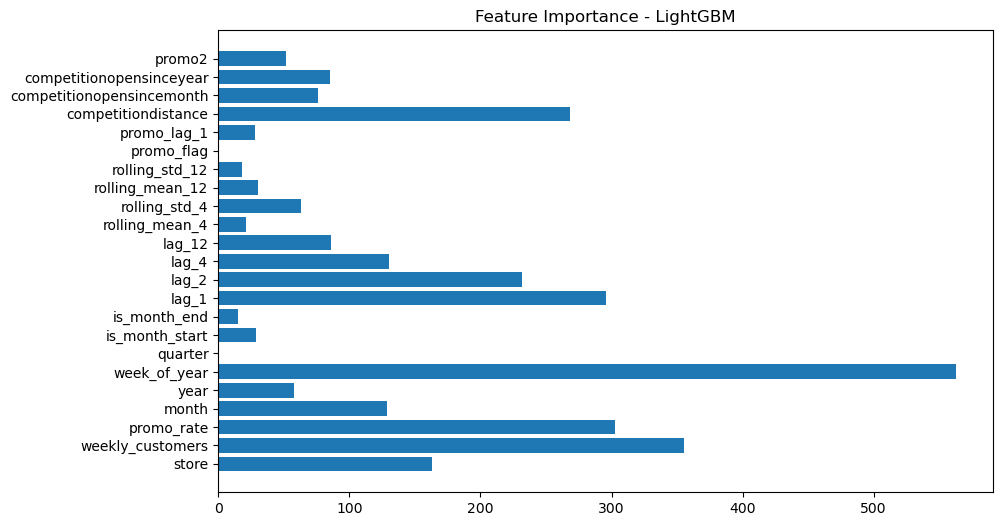

In [ ]:
import matplotlib.pyplot as plt

lgm.feature_importances_

plt.figure(figsize=(10,6))
plt.barh(X_train.columns, lgm.feature_importances_)
plt.title("Feature Importance - LightGBM")
plt.show()
